# Intro

### Credits
This notebook is based on the famous [Fastai with 🤗 Transformers (BERT, RoBERTa, ...)](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta) article from [Maximilien Roberti](https://www.kaggle.com/maroberti). I have implemented a few minor tweaks.

The data cleaning part is from [Alexander Tesemnikov](https://www.kaggle.com/alexandertesemnikov/bert-pytorch-pretrained-fine-tuning). Erroneous classification cleanups are from [Sokol Heavy](https://www.kaggle.com/sokolheavy/multi-dropout-aug-oof).

**If you find this notebook helpful, please upvote their input! 🙏🙂**

### Short Info

* **fast.ai** Databunch and Learner
* **Hugging Face** transformers Library
* **RoBERTa** (multiple other architectures are also included)
* **Google Colab** Environment



# 0 Google Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# 1 Import Libraries



In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

#Check the present working directory using pwd command

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.optim as optim

import random
import string

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

#2 Load Data

In [ ]:
!kaggle competitions download -c nlp-getting-started

In [ ]:
path=Path("/content/gdrive/My Drive/Kaggle")

In [ ]:
train_df= pd.read_csv(path/"train.csv")
test_df= pd.read_csv(path/"test.csv")
sample_df= pd.read_csv(path/"sample_submission.csv")

In [ ]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train_df.loc[train_df['id'].isin(ids_with_target_error),'target'] = 0

In [ ]:
train_df = train_df[["text","target"]]
test_df = test_df[['text','id']]

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
def clean(text):
    """
    Text preprocessing function.
    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_df['clean_text'] = train_df['text'].apply(lambda x:clean(x))
test_df['clean_text'] = test_df['text'].apply(lambda x:clean(x))

# 3 Definition of Models

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [ ]:
# Parameters
seed = 42
epochs=15
use_fp16=True
bs=32
discriminative=False
max_seq_len=128

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(seed)

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

# 4 Databunch Creation

In [ ]:
databunch = (TextList.from_df(train_df, cols='clean_text', processor=transformer_processor)
             .split_by_rand_pct(0.01,seed=seed)
             .label_from_df(cols= 'target')
             .add_test(test_df)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
config.max_length = max_seq_len

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# 5 Model Creation

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

In [ ]:
learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

In [ ]:
# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [ ]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

# 6 Optimization of Model

In [ ]:
learner.save('bert-untrained')

In [ ]:
seed_all(seed)
learner.load('bert-untrained')

## 6.1 Round 1: Layer Freeze -1

In [ ]:
learner.freeze_to(-1)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-04
Min loss divided by 10: 6.31E-04


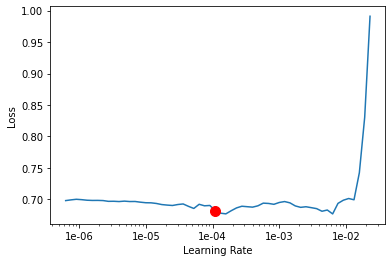

In [ ]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.578403,0.559963,0.828947,0.171053,00:08


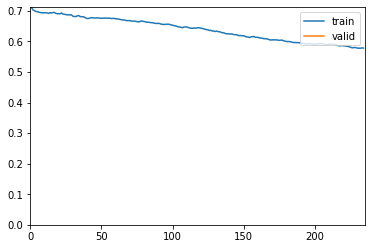

In [ ]:
learner.fit_one_cycle(1, max_lr=1.10E-04)

In [ ]:
learner.save('bert-first-cycle')

## 6.2 Round 2: Layer Freeze -2

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-04
Min loss divided by 10: 5.25E-06


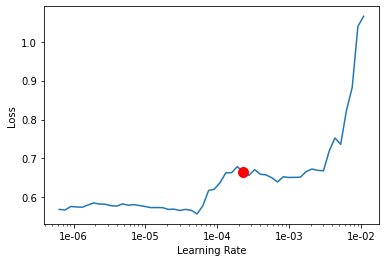

In [ ]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.426801,0.400703,0.855263,0.144737,00:10


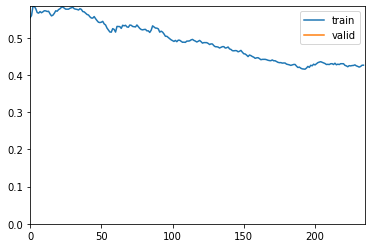

In [ ]:
learner.fit_one_cycle(1, max_lr=4E-05)

In [ ]:
learner.save('bert-second-cycle')

## 6.3 Round 3: Layer Freeze -3

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.32E-07


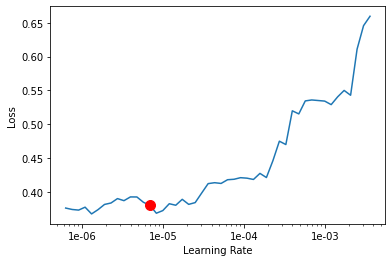

In [ ]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.401746,0.396721,0.868421,0.131579,00:13


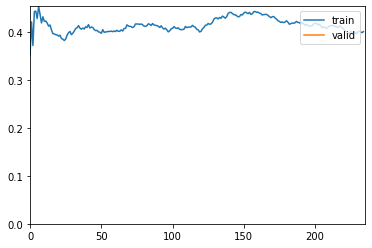

In [ ]:
learner.fit_one_cycle(1, max_lr=6.92E-06)

In [ ]:
learner.save('bert-third-cycle')

## 6.4 Round 4: Unfreeze all Layers

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.91E-07


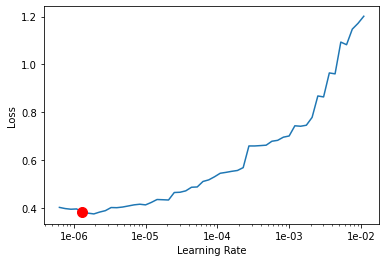

In [ ]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.382316,0.390725,0.842105,0.157895,00:35


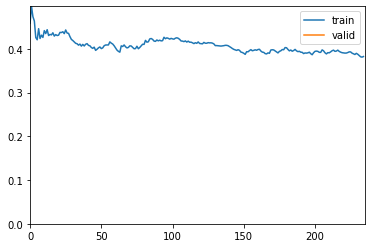

In [ ]:
learner.fit_one_cycle(1, max_lr=1.32E-06)

In [ ]:
learner.save('bert-fourth-cycle')

In [ ]:
seed_all(seed)
learner.load('bert-third-cycle');

# 7 Submission to Kaggle

In [ ]:
sub_df=test_df

In [ ]:
sub_df['target'] = sub_df['clean_text'].apply(lambda x:int(learner.predict(x)[1]))

In [ ]:
final_sub = sub_df[['id','target']]
final_sub.to_csv(path/"roberta.csv", index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f roberta.csv -m "RoBERTa"